In [1]:
%load_ext autoreload
%autoreload 2
import cv2 as cv
import numpy as np
import xarray as xr

from ocr.risks.fire import generate_wind_directional_kernels

Set up a test case that includes both nans at the corner (where we expect them) but also nans in the interior where we think they might be as well)

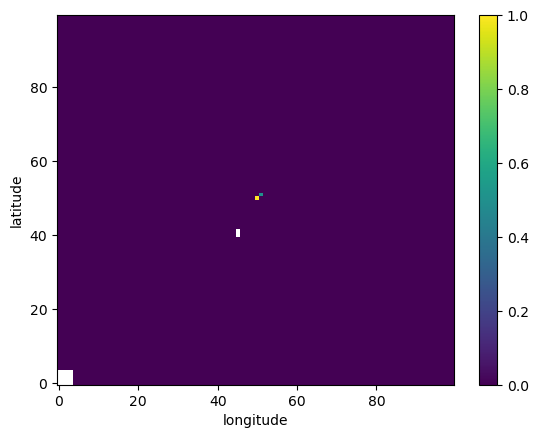

In [2]:
nx, ny = 100, 100
data = np.zeros((nx, ny), dtype=np.float32)
data[nx // 2, ny // 2] = 1.0  # impulse at center
data[nx // 2 + 1, ny // 2 + 1] = 0.5
data[0:4, 0:4] = np.nan
data[40:42, 45] = np.nan
da = xr.DataArray(
    data, dims=['latitude', 'longitude'], coords={'latitude': range(nx), 'longitude': range(ny)}
)
da.plot();

In [3]:
weights_dict = generate_wind_directional_kernels()

In [4]:
spread_results = xr.Dataset(
    data_vars={var_name: (da.dims, da.values) for var_name in weights_dict.keys()},
    coords=da.coords,
    attrs=da.attrs,
)

In [12]:
# Get latitude and longitude coordinates from the original data
lat_coords = da.latitude
lon_coords = da.longitude
directions = list(weights_dict.keys())

# Initialize arrays to store results for all directions
n_dirs = len(directions)
n_lat = len(lat_coords)
n_lon = len(lon_coords)

valid_masks = np.zeros((n_dirs, n_lat, n_lon), dtype=np.float32)
convolved_masks = np.zeros((n_dirs, n_lat, n_lon), dtype=np.float32)
convolved_arrs = np.zeros((n_dirs, n_lat, n_lon), dtype=np.float32)
output_arrs = np.zeros((n_dirs, n_lat, n_lon), dtype=np.float32)

# Fill the arrays
for i, (direction, weights) in enumerate(weights_dict.items()):
    arr = spread_results[direction].values
    nan_mask = np.isnan(arr)
    # the cv.filter2D routine doesn't have an option to ignore nans, so it will propagate them.
    # due to reprojections we are almost guaranteed to have nans in the corners of regions, and those
    # can get propagated very far amidst multiple iterations of convolutions!
    # so, we will cast them to zeros for this step. two notes:
    # 1) this will NOT influence our results, which only accounts for positive values,
    # because any NaNs will be cast into zeros, and so will just be kept track of in the
    # convolved_mask object explained below.
    # 2) we will retain the nans and add them back in using `nan_mask` defined above. this step is inspired by the need
    # to accomodate nans introduced around the corners of each region we are working in as a result of
    # reprojection/cropping issues. we have steps in the `calculated_wind_adjusted_risk` function
    # which crop out the expected bad data
    # (e.g. `riley_2011_30m_4326_subset = riley_2011_30m_4326_subset.sel(latitude=y_slice, longitude=x_slice)`
    # however, in case there are nans introduced for some other reason we want to make sure we don't
    # mistakenly hide those. so, we'll add them back in after all iterations of the convolution are done
    arr = np.nan_to_num(arr, nan=0.0)
    for iterations in np.arange(0, 3):
        # valid_mask is wherever we have positive numbers. we only want to spread numbers informed by non-zero numbers - we are
        # performing an additive method here by spreading burn probability. so, we keep track of which pixels are positive, or valid
        # for spreading. valid_mask will get progressively bigger throughout the runs because 0 values will disappear.
        valid_mask = (arr > 0).astype(np.float32)
        # convolved_mask is the fraction the contributing area for each pixel which is from non-zero values (if the values is 1 it is entirely
        # valid values and doesn't need to be adjusted, if the value is 0 it is entirely zero values and there are no valid values in the mask
        # if there were only one valid pixel contributing to the kernel it would make a very tiny positive number
        # dividing by the convolved_mask value will essentially extract out the zeros which have been averaged into the
        # convolved_arr.
        convolved_mask = cv.filter2D(valid_mask, ddepth=-1, kernel=weights)
        # because things can get unstable at very small numbers, we remove the tiny values and cast them to zero
        # this introduces an assumption that we are not spreading
        convolved_mask = np.where(convolved_mask < 10e-12, 0.0, convolved_mask)
        # convolved_arr is the array after having the filter applied to it. any zeros within the filter have been pulled into the averaging.
        convolved_arr = cv.filter2D(arr, ddepth=-1, kernel=weights)
        convolved_arr = np.where(convolved_arr < 10e-12, 0.0, convolved_arr)
        # output_arr is the final result. wherever the convolved_mask is 0 there was no contribution of valid pixels
        # to the convolution, so it should just be zero. wherever convolved_mask is greater than 0 that means there
        # was at least one valid pixel in the filter contributing so it should get a non-zero number! however, we want
        # to extract out all of the zeros that might have supressed that number. we do that by renormalizing by the
        # value of the convolved_mask. for example, if the convolved_mask value for a pixel is 1, it means that all
        # the pixels in that area were non-zero and so the value doesn't need to be adjusted. if the value is 0.5,
        # that means that half of the pixels in that kernel were zeros, so the final convolved pixel value was
        # diluted in half by zeros. to compensate we divide the `convolved_arr` value by the `convolved_mask` value,
        # in this example, dividing by 0.5 and thus dubling the `convoled_arr` value. this is an around-the-way
        # approach to essentially treat those zeros as nans and applying a `ignore_nans` flag!
        # NOTE: we renormalize by the convolved_mask every iteration because we want to make this correction every time
        # as opposed to going back after the fact.
        output_arr = np.where(convolved_mask > 0, convolved_arr / convolved_mask, 0.0)
        output_arr = np.where(output_arr < 0, 0.0, output_arr)

        valid_masks[i] = valid_mask
        convolved_masks[i] = convolved_mask
        convolved_arrs[i] = convolved_arr
        output_arrs[i] = output_arr
        arr = output_arr
    np.testing.assert_equal((output_arr < 0).sum(), 0)
    # add back in nans at the very end after iterations done. use the `nan_mask` to do this. this will
    # make sure that any nans are retained, whether they're ones we expect or ones we didn't! and so
    # we'll make sure they can trigger tests later on in the processing steps
    output_arrs[i] = np.where(nan_mask, np.nan, output_arrs[i])
# Create the xarray Dataset
results = xr.Dataset(
    {
        'valid_mask': (['direction', 'latitude', 'longitude'], valid_masks),
        'convolved_mask': (['direction', 'latitude', 'longitude'], convolved_masks),
        'convolved_arr': (['direction', 'latitude', 'longitude'], convolved_arrs),
        'output_arr': (['direction', 'latitude', 'longitude'], output_arrs),
    },
    coords={
        'direction': directions,
        'latitude': lat_coords,
        'longitude': lon_coords,
    },
)

results

/var/folders/cy/f4hy2pds5wv4xmsxm6vczyf80000gn/T/ipykernel_93937/3697528498.py:64: RuntimeWarning: invalid value encountered in divide
  output_arr = np.where(convolved_mask > 0, convolved_arr / convolved_mask, 0.0)


<xarray.Dataset> Size: 1MB
Dimensions:         (direction: 8, latitude: 100, longitude: 100)
Coordinates:
  * direction       (direction) <U2 64B 'W' 'NW' 'N' 'NE' 'E' 'SE' 'S' 'SW'
  * latitude        (latitude) int64 800B 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
  * longitude       (longitude) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables:
    valid_mask      (direction, latitude, longitude) float32 320kB 0.0 ... 0.0
    convolved_mask  (direction, latitude, longitude) float32 320kB 0.0 ... 0.0
    convolved_arr   (direction, latitude, longitude) float32 320kB 0.0 ... 0.0
    output_arr      (direction, latitude, longitude) float32 320kB nan ... 0.0

# 1 iteration

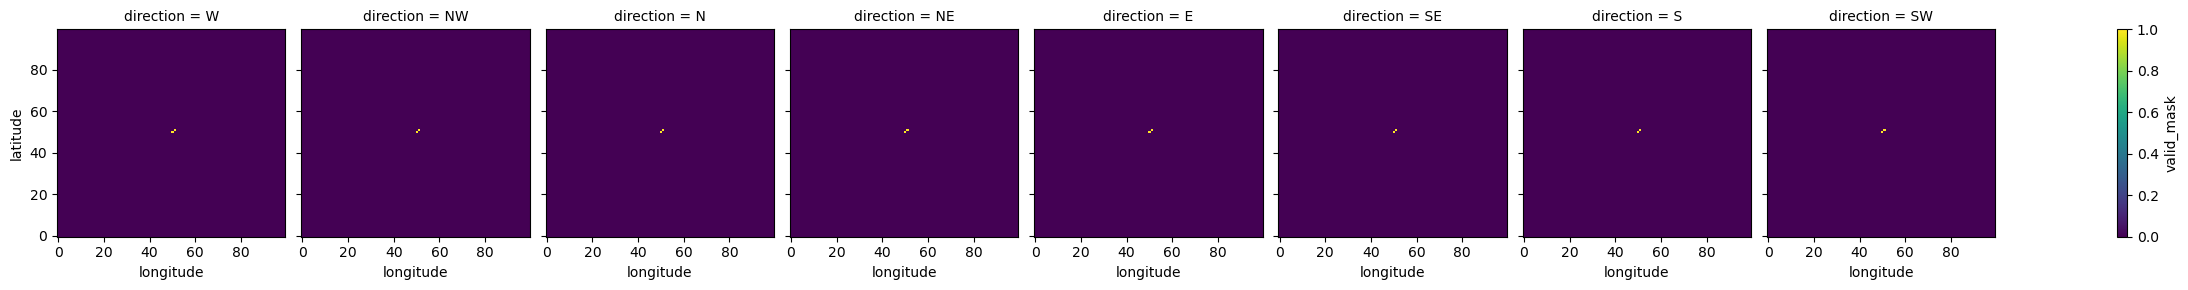

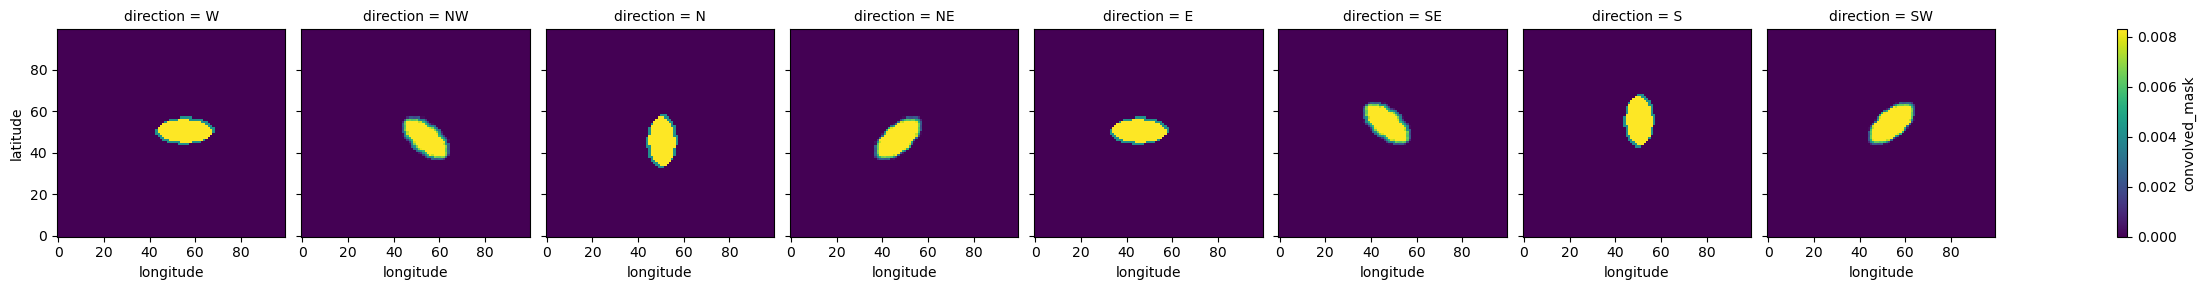

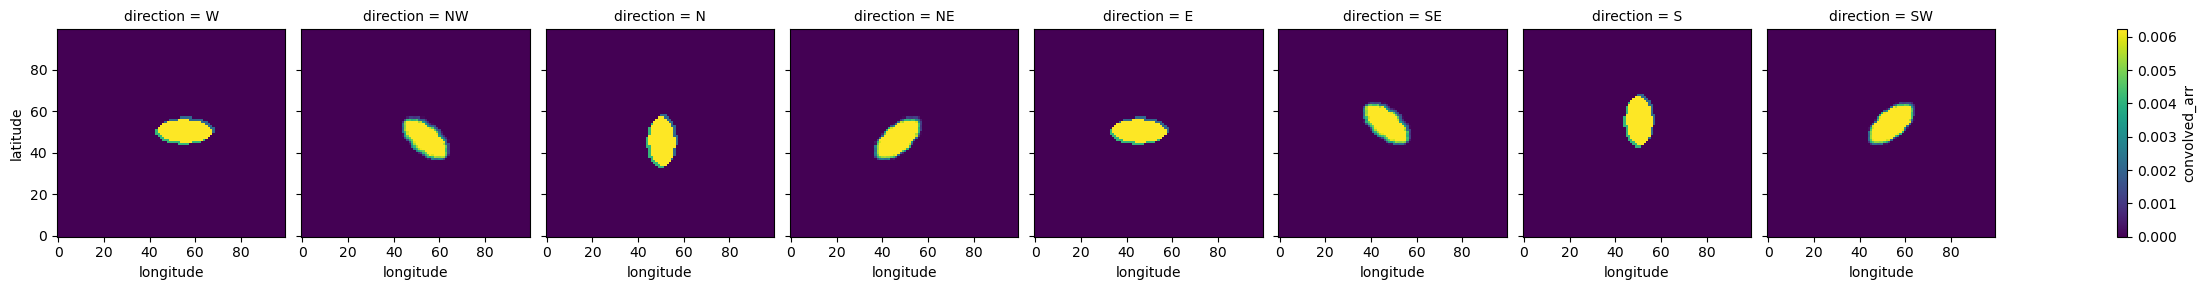

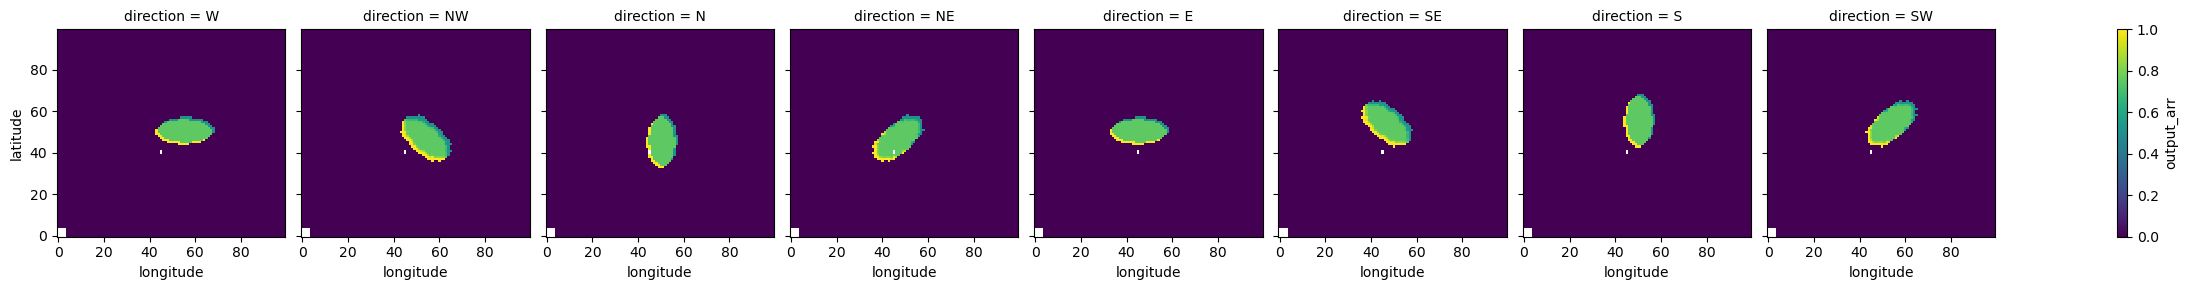

In [9]:
results['valid_mask'].plot(col='direction')
results['convolved_mask'].plot(col='direction')
results['convolved_arr'].plot(col='direction')
results['output_arr'].plot(col='direction');

# 2 iterations

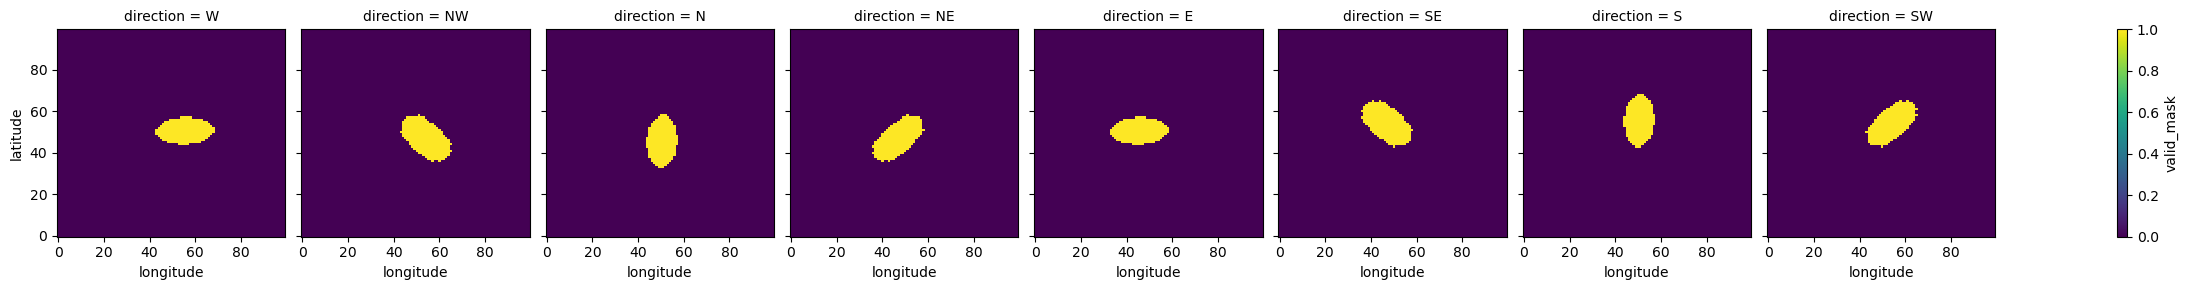

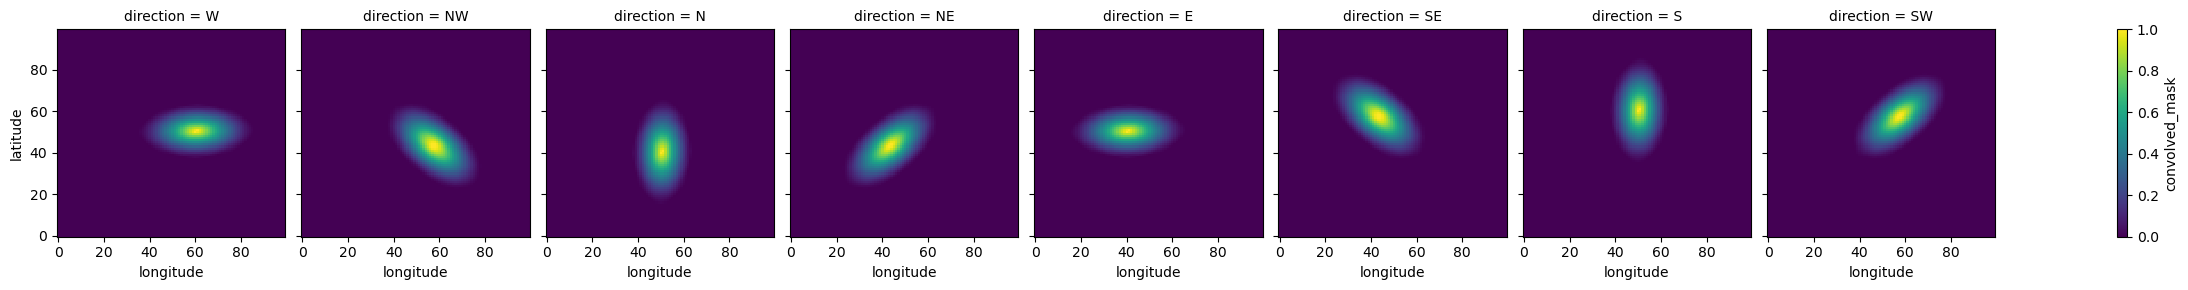

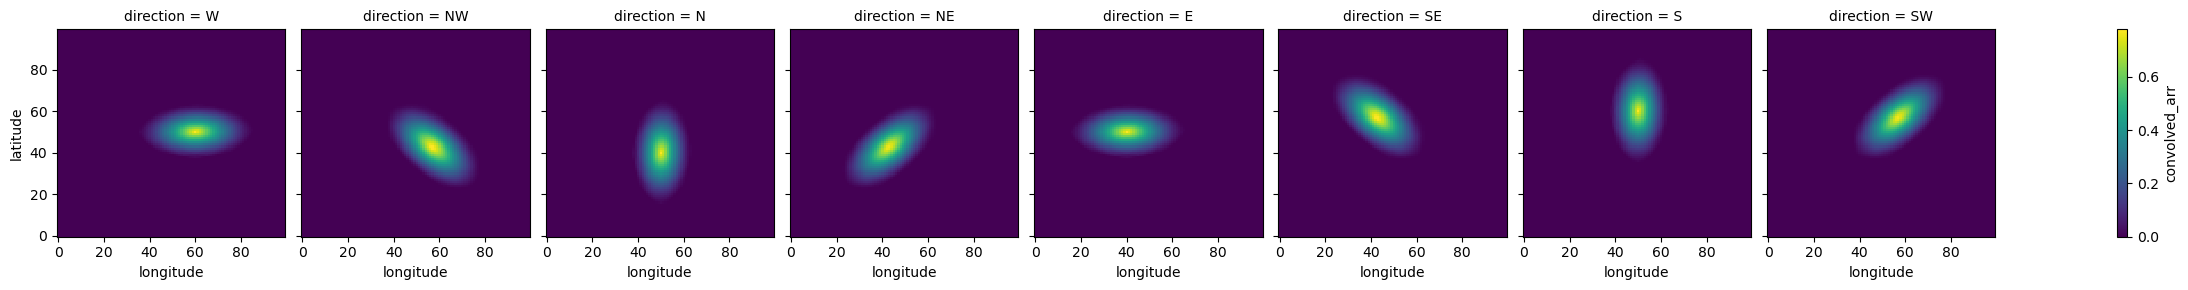

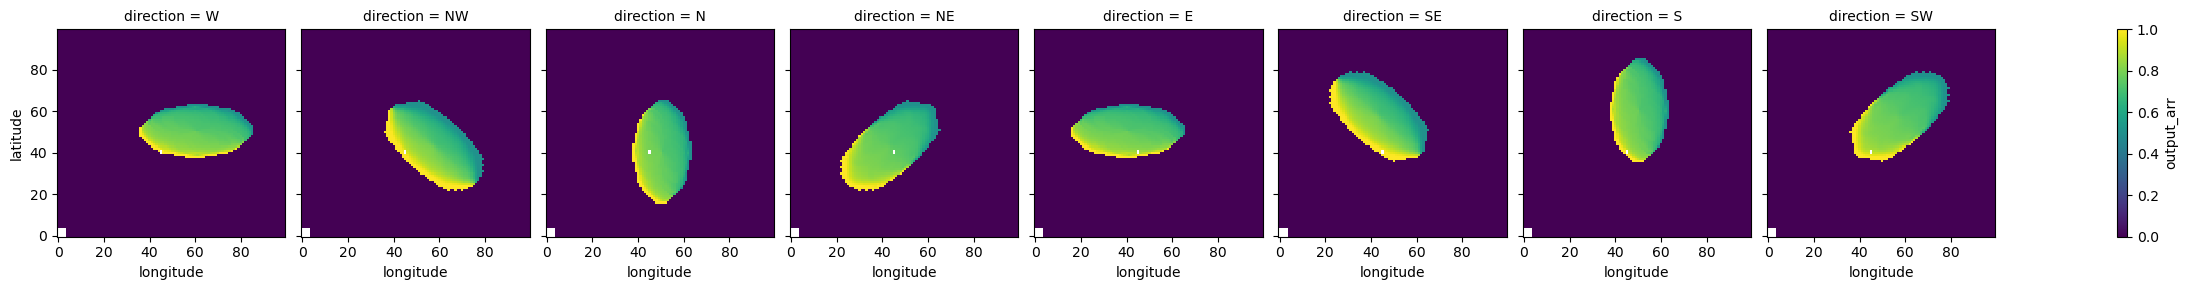

In [11]:
results['valid_mask'].plot(col='direction')
results['convolved_mask'].plot(col='direction')
results['convolved_arr'].plot(col='direction')
results['output_arr'].plot(col='direction');

# 3 iterations

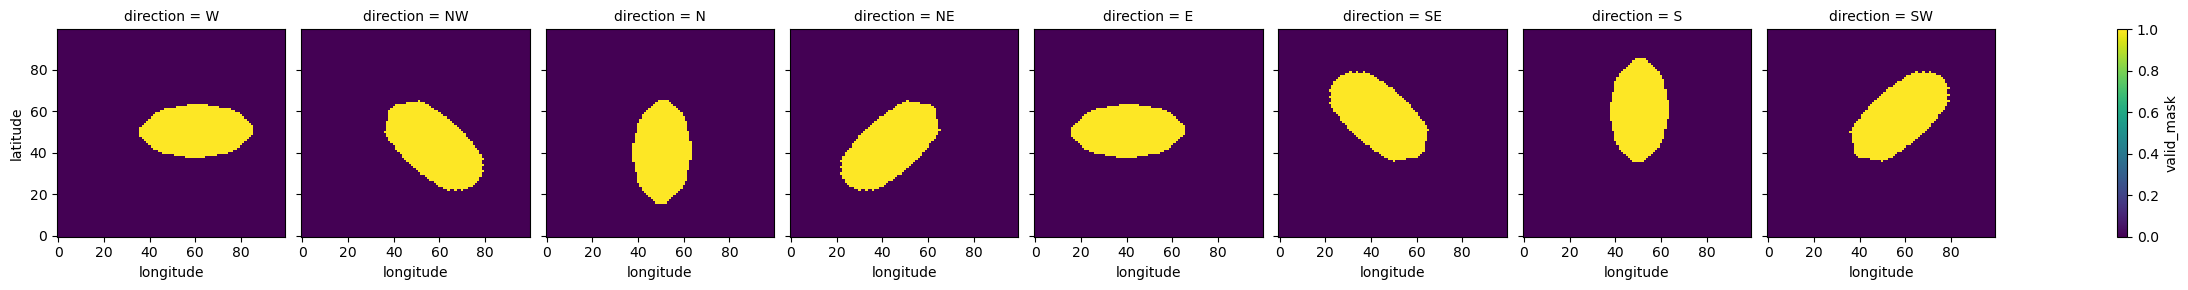

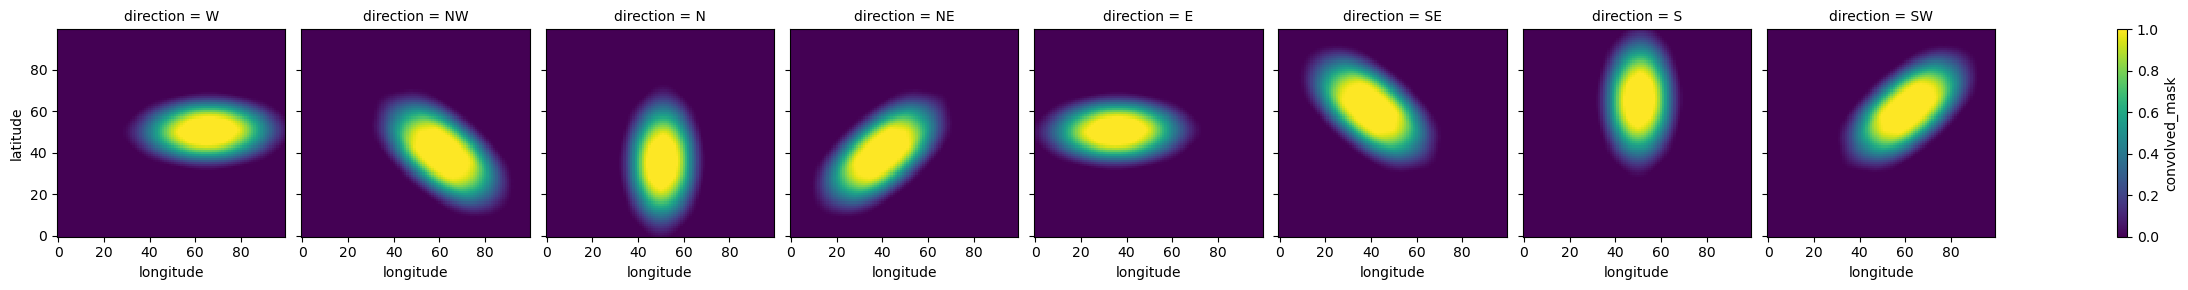

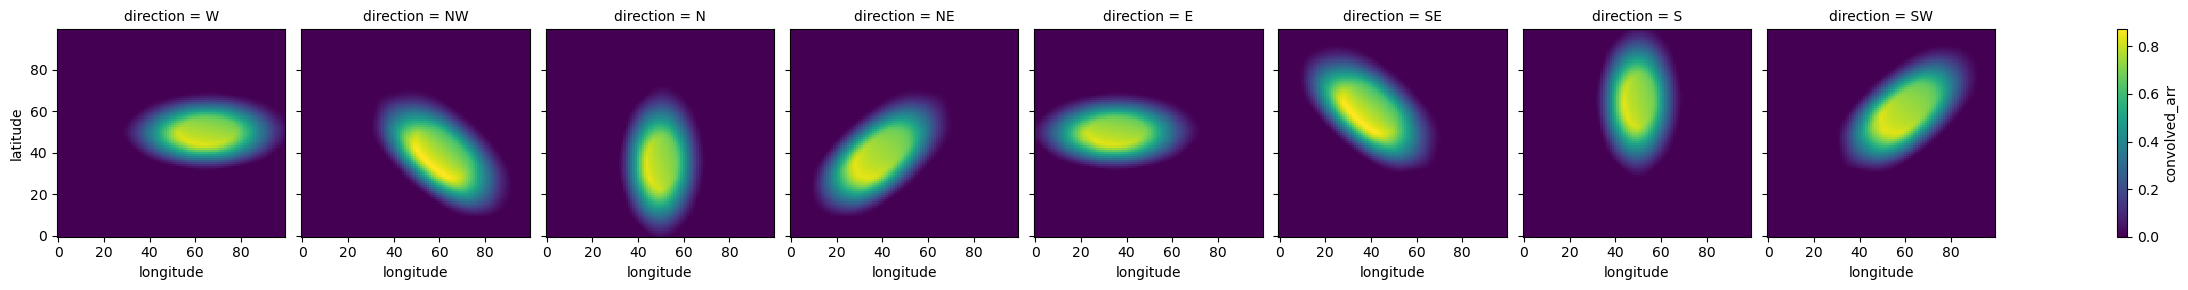

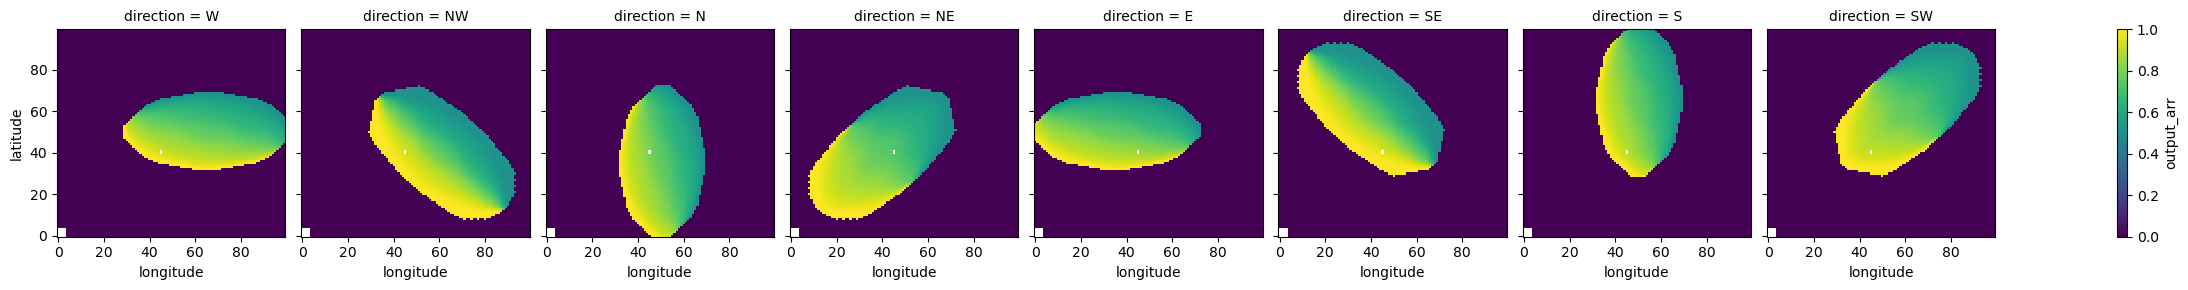

In [13]:
results['valid_mask'].plot(col='direction')
results['convolved_mask'].plot(col='direction')
results['convolved_arr'].plot(col='direction')
results['output_arr'].plot(col='direction');

In [21]:
# Let's test the difference between NaN and 0 in convolution
# Create a simple test case

test_data = np.array(
    [[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, np.nan, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]],
    dtype=np.float32,
)

# Simple uniform kernel
test_kernel = np.ones((3, 3), dtype=np.float32) / 9

print('Original test data:')
print(test_data)
print('\nKernel (3x3 uniform, normalized):')
print(test_kernel)

# Scenario 1: Convolve with NaN present
result_with_nan = cv.filter2D(test_data, ddepth=-1, kernel=test_kernel)
print('\nConvolution WITH NaN:')
print(result_with_nan)

# Scenario 2: Replace NaN with 0 before convolving
test_data_no_nan = np.nan_to_num(test_data, nan=0.0)
result_without_nan = cv.filter2D(test_data_no_nan, ddepth=-1, kernel=test_kernel)
print('\nConvolution WITHOUT NaN (replaced with 0):')
print(result_without_nan)

Original test data:
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0. nan  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]

Kernel (3x3 uniform, normalized):
[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]

Convolution WITH NaN:
[[0.         0.22222222 0.22222222 0.22222222 0.        ]
 [0.                nan        nan        nan 0.        ]
 [0.                nan        nan        nan 0.        ]
 [0.                nan        nan        nan 0.        ]
 [0.         0.         0.         0.         0.        ]]

Convolution WITHOUT NaN (replaced with 0):
[[0.         0.22222222 0.22222222 0.22222222 0.        ]
 [0.         0.11111111 0.11111111 0.11111111 0.        ]
 [0.         0.11111111 0.11111111 0.11111111 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


In [30]:
# Now let's see what happens with our normalized approach
# (which divides by the convolved mask)

print('=' * 60)
print('OUR APPROACH: Normalized convolution')
print('=' * 60)

# With NaN → 0 replacement
arr_clean = np.nan_to_num(test_data, nan=0.0)
valid_mask = (arr_clean > 0).astype(np.float32)

print('\nValid mask (where data > 0):')
print(valid_mask)

convolved_mask = cv.filter2D(valid_mask, ddepth=-1, kernel=test_kernel)
print('\nConvolved mask (sum of weights over valid pixels):')
print(convolved_mask)

convolved_arr = cv.filter2D(arr_clean, ddepth=-1, kernel=test_kernel)
print('\nConvolved array (weighted sum):')
print(convolved_arr)

output = np.where(convolved_mask > 0, convolved_arr / convolved_mask, 0.0)
print('\nNormalized output (convolved_arr / convolved_mask):')
print(output)

print('\n' + '=' * 60)
print('KEY INSIGHT:')
print('=' * 60)
print('At position (1, 2) where original value was 1:')
print(f'  - Without normalization: {result_without_nan[1, 2]:.6f}')
print(f'  - With normalization: {output[1, 2]:.6f}')
print(f'  - Original value preserved: {np.isclose(output[1, 2], 1.0)}')
print('\nThe normalization corrects for missing neighbors!')

OUR APPROACH: Normalized convolution

Valid mask (where data > 0):
[[0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

Convolved mask (sum of weights over valid pixels):
[[0.         0.22222222 0.22222222 0.22222222 0.        ]
 [0.         0.11111111 0.11111111 0.11111111 0.        ]
 [0.         0.11111111 0.11111111 0.11111111 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]

Convolved array (weighted sum):
[[0.         0.22222222 0.22222222 0.22222222 0.        ]
 [0.         0.11111111 0.11111111 0.11111111 0.        ]
 [0.         0.11111111 0.11111111 0.11111111 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]

Normalized output (convolved_arr / convolved_mask):
[[0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

KEY INSIGHT:
At position (1, 2

/var/folders/x0/v8j9bc4962dbwg_w3gytvf080000gn/T/ipykernel_63523/2319113818.py:23: RuntimeWarning: invalid value encountered in divide
  output = np.where(convolved_mask > 0, convolved_arr / convolved_mask, 0.0)


In [31]:
# Let's test a scenario with actual data values near the NaN/0 location
print('=' * 60)
print('TEST: Do zeros dilute nearby values?')
print('=' * 60)

test_with_values = np.array(
    [
        [0, 0, 0.5, 0, 0],
        [0, 0, 1.0, 0, 0],
        [0, 0, np.nan, 0, 0],  # NaN will become 0
        [0, 0, 0.8, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    dtype=np.float32,
)

print('Test data (with values 0.5, 1.0, NaN, 0.8 in column 2):')
print(test_with_values)

# Process with our approach
arr_clean = np.nan_to_num(test_with_values, nan=0.0)
valid_mask = (arr_clean > 0).astype(np.float32)
convolved_mask = cv.filter2D(valid_mask, ddepth=-1, kernel=test_kernel)
convolved_arr = cv.filter2D(arr_clean, ddepth=-1, kernel=test_kernel)
output = np.where(convolved_mask > 0, convolved_arr / convolved_mask, 0.0)

print('\nNormalized output:')
print(output)

print('\n' + '=' * 60)
print('ANALYSIS at position (2, 2) where NaN was replaced with 0:')
print('=' * 60)
print(f'Output value: {output[2, 2]:.6f}')
print(f'Expected (avg of neighbors): {(0.5 + 1.0 + 0.8) / 3:.6f}')
print('\nThe 0 (from NaN) is NOT included in the average!')
print('Only the valid neighbors (mask > 0) contribute.')
print("\nConclusion: Zeros don't dilute values; they're excluded via the mask.")

TEST: Do zeros dilute nearby values?
Test data (with values 0.5, 1.0, NaN, 0.8 in column 2):
[[0.  0.  0.5 0.  0. ]
 [0.  0.  1.  0.  0. ]
 [0.  0.  nan 0.  0. ]
 [0.  0.  0.8 0.  0. ]
 [0.  0.  0.  0.  0. ]]

Normalized output:
[[0.         0.8333334  0.8333334  0.8333334  0.        ]
 [0.         0.75       0.75       0.75       0.        ]
 [0.         0.90000004 0.90000004 0.90000004 0.        ]
 [0.         0.8        0.8        0.8        0.        ]
 [0.         0.8        0.8        0.8        0.        ]]

ANALYSIS at position (2, 2) where NaN was replaced with 0:
Output value: 0.900000
Expected (avg of neighbors): 0.766667

The 0 (from NaN) is NOT included in the average!
Only the valid neighbors (mask > 0) contribute.

Conclusion: Zeros don't dilute values; they're excluded via the mask.


/var/folders/x0/v8j9bc4962dbwg_w3gytvf080000gn/T/ipykernel_63523/2726638791.py:22: RuntimeWarning: invalid value encountered in divide
  output = np.where(convolved_mask > 0, convolved_arr / convolved_mask, 0.0)


In [32]:
# Check for NaNs in each variable
print('Original data NaNs:', np.isnan(da.values).sum())
print('\nNaNs per direction in output_arr:')
for direction in results.direction.values:
    nan_count = np.isnan(results['output_arr'].sel(direction=direction).values).sum()
    print(f'  {direction}: {nan_count}')

print('\nNaNs per direction in convolved_mask:')
for direction in results.direction.values:
    nan_count = np.isnan(results['convolved_mask'].sel(direction=direction).values).sum()
    print(f'  {direction}: {nan_count}')

Original data NaNs: 6

NaNs per direction in output_arr:
  W: 0
  NW: 0
  N: 0
  NE: 0
  E: 0
  SE: 0
  S: 0
  SW: 0

NaNs per direction in convolved_mask:
  W: 0
  NW: 0
  N: 0
  NE: 0
  E: 0
  SE: 0
  S: 0
  SW: 0


In [33]:
# Check where NaNs appear in output_arr
direction = 'N'
output = results['output_arr'].sel(direction=direction).values
conv_mask = results['convolved_mask'].sel(direction=direction).values
conv_arr = results['convolved_arr'].sel(direction=direction).values

print(f'For direction {direction}:')
print(f'  output_arr NaNs: {np.isnan(output).sum()}')
print(f'  convolved_arr NaNs: {np.isnan(conv_arr).sum()}')
print(f'  convolved_mask zeros: {(conv_mask == 0).sum()}')
print(f'  convolved_mask NaNs: {np.isnan(conv_mask).sum()}')

# Check if NaNs in output correspond to zeros in convolved_mask
nan_mask = np.isnan(output)
print('\nWhere output_arr is NaN:')
print(f'  convolved_mask is zero: {(conv_mask[nan_mask] == 0).sum()} / {nan_mask.sum()}')
print(f'  convolved_mask is NaN: {np.isnan(conv_mask[nan_mask]).sum()}')
print(f'  convolved_arr is NaN: {np.isnan(conv_arr[nan_mask]).sum()}')

For direction N:
  output_arr NaNs: 0
  convolved_arr NaNs: 0
  convolved_mask zeros: 643
  convolved_mask NaNs: 0

Where output_arr is NaN:
  convolved_mask is zero: 0 / 0
  convolved_mask is NaN: 0
  convolved_arr is NaN: 0
